# Main Analysis Notebook

## Introduction

In this notebook, we perform the main analysis for the paper **"Modeling Decision-Making Under Uncertainty with Qualitative Outcomes"** by Korem et al., 2025 PLoS Comp. Biology.

The goal is to model decision-making under uncertainty with qualitative outcomes. We aim to compare the performance of different models on data derived from risk and ambiguity tasks in both monetary and medical contexts.

### Task Design

The tasks involve decision-making scenarios where participants choose between options with varying levels of risk and ambiguity. There are 84 trials with the following parameters:

#### Monetary Task
- **Values**: 5, 8, 12, 25
- **Risk**: 0.25, 0.5, 0.75
- **Ambiguity**: 0, 0.24, 0.5, 0.74 (When ambiguity > 0, risk = 0.5)

#### Medical Task
- **Values**:
  - Slight Improvement
  - Moderate Improvement
  - Complete Recovery
- **Risk**: Same as the monetary task
- **Ambiguity**: Same as the monetary task

### Models

We will build and evaluate the following models:
1. Regression (no individual parameters) - straw man
2. Utility Function
3. Utility function with trembling hand choice function
4. Estimated Value Model for Medical Task



## Libraries Used

First, we import the necessary libraries for data manipulation, probabilistic programming, and visualization.


In [1]:
# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation

# Probabilistic programming and Bayesian statistical modeling
import pymc as pm  
import arviz as az  

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns  

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

## Load Preprocessed Data

### Load Cleaned Data

In [2]:
db_mon = pd.read_csv('data/mon_clean.csv')
db_med = pd.read_csv('data/med_clean.csv')

db_mon_online = pd.read_csv('data_online/mon_clean.csv')
db_med_online = pd.read_csv('data_online/med_clean.csv')

print('Participants in-person: ', len(db_mon['sub'].unique()), '\nparticipants online: ', len(db_mon_online['sub'].unique()))

Participants in-person:  66 
participants online:  332


### Extract Indices and Subject Numbers

In [3]:
# Assign a unique serial number for each participant.
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int) - 1
db_mon_online['subn'] = db_mon_online['sub'].rank(method='dense').astype(int) - 1


# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = db_mon['subn'].unique().shape[0]
n_subs_online = db_mon_online['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = db_mon.subn.tolist()
sub_idx_online = db_mon_online.subn.tolist()

# Assign a unique serial number for each participant. This will be useful for indexing operations.
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int) - 1
db_med_online['subn'] = db_med_online['sub'].rank(method='dense').astype(int) - 1


# Count the number of unique subjects in the 'db_med' dataset.
n_subs_med = db_med['subn'].unique().shape[0]
n_subs_med_online = db_med_online['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_med' dataset.
sub_idx_med = db_med.subn.tolist()
sub_idx_med_online = db_med_online.subn.tolist()

## Model Building and Evaluation

### 1. Straw Man Model

The Straw Man model serves as a baseline for evaluating decision-making under uncertainty with qualitative outcomes. This model makes the simplest possible assumptions:
- It does not account for individual parameters such as ambiguity attitude.
- It assumes that each category is linearly better than the previous one, with each category being +1 better than the last.

The goal of this model is to establish a baseline against which more complex qualitative data models can be compared.

In [4]:
def straw_man(df, n_subs, idx):
    """
    A simple model (straw man) that tries to estimate the influence of value, risk, and ambiguity 
    on the choice made by subjects in a gambling scenario.

    Parameters:
    - df: DataFrame containing data on choice, value, risk, and ambiguity for each trial
    - n_subs: Number of subjects in the study
    - idx: Subject index for each trial (used for hierarchical modeling)

    Returns:
    - trace: Samples from the posterior distribution
    """
    
    with pm.Model() as simple:  # Define a new PyMC3 model
    
        # Define hyperpriors for the group-level parameter (γ)
        gMu = pm.Normal('gMu',  0, 1) # Mean of the normal distribution
        gSig = pm.Gamma('gSig', 2, 1) # Standard deviation (Gamma distribution provides only positive values)

        # Define the subject-specific risk preference (γ) using a lognormal distribution
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # Compute expected value of the lottery outcome
        val  = df['value'].values                                # Values from the 'value' column in the DataFrame
        prob = df['risk'].values - (df['ambiguity'].values / 2)  # Probability calculation adjusted by ambiguity

        svLotto = val * prob # Subjective value of the lottery
        svRef   = 1          # Subjective value of a reference (assumed to be 1)

        # Define the linear predictor (p) and compute the expected probability (mu) using the inverse logit function
        p  = (svLotto - svRef) / γ[idx]
        mu =  pm.invlogit(p)                     # The invlogit function transforms values to the (0,1) interval

        # Define the likelihood of the observed data. A binomial likelihood is chosen because the outcome is binary (choice is 0 or 1)
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

### 2. Utility Function Model

In this model, we use the utility function based on Kahneman and Tversky's Prospect Theory (1979), incorporating two subjective parameters: risk attitude (α) and ambiguity attitude (β).

#### Model Parameters:

- **Risk Attitude (α):**
  - α = 1: Risk neutral
  - α < 1: Risk averse (concave utility function)
  - α > 1: Risk seeking (convex utility function)

- **Ambiguity Attitude (β):**
  - β = 0: Ambiguity neutral
  - β > 0: Ambiguity averse
  - β < 0: Ambiguity seeking

#### Hyper Priors:
- **Risk Aversion (α):** 0.7
- **Ambiguity Aversion (β):** 0.65 (based on Levy et al., 2010)

In [5]:
def Utility(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence.

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for utility function
    with pm.Model() as Utility:
        
        # Hyperpriors define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 0)  # Shape parameter for risk attitude
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 3, lower = 0)  # Rate parameter for risk attitude
        bMu     = pm.Normal('bMu',   .65, 1)  # Group-level mean for ambiguity modulation
        bSig = pm.Gamma('bSig', 2, 1)     # Standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs) # Subject-specific utility curvature
        α     = pm.Deterministic('α', alpha * 2) # Scale the value of alpha
        β     = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs) # Ambiguity modulation
        γ     = pm.LogNormal('γ', 0, .25, shape = n_subs) # Inverse temperature parameter

        # Calculate the expected value of the outcome using a power function.
        value = df['value'].values ** α[idx]  # Subjective value based on curvature parameter
        prob  = df['risk'].values  - (β[idx] * (df['ambiguity'].values/2))  # Probability of outcome considering ambiguity

        # Calculate the subjective value (SV) of the lottery for each trial
        svLotto = value * prob
        svRef   = 5 ** α[idx]  # Reference value

        # Convert SV into a probability of choosing the lottery using the inverse logit function.
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Define the likelihood of observations using a Binomial distribution, as the choice is binary.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
           
    return(trace)

## 3. Utility Function with Trembling Hand Choice Function

In this model, we modify the Utility Function model by replacing the softmax choice function with a trembling hand choice function based on Krefeld-Schwalb et al., 2022.

### Model Parameters:

- **Risk Attitude (α):**
  - α = 1: Risk neutral
  - α < 1: Risk averse (concave utility function)
  - α > 1: Risk seeking (convex utility function)

- **Ambiguity Attitude (β):**
  - β = 0: Ambiguity neutral
  - β > 0: Ambiguity averse
  - β < 0: Ambiguity seeking

- **Trembling Hand Parameter (γ):**
  - γ: Probability of making a choice randomly rather than according to the utility function.


In [6]:
def Utility_th(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence, with a modified choice function incorporating tremble hand effect (γ).

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for the utility function
    with pm.Model() as trembel_hand:
        
        # Hyperpriors: Define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 0)  # Shape parameter for utility curvature
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 3, lower = 0)  # Rate parameter for utility curvature

        g_a = pm.TruncatedNormal('g_a', 2, 1, lower = 1)  # Shape parameter for tremble hand effect
        g_b = pm.TruncatedNormal('g_b', 2, 1, lower = 1)  # Rate parameter for tremble hand effect

        bMu  = pm.Normal('bMu', .65, 1)  # Mean for ambiguity modulation
        bSig = pm.Gamma('bSig', 2, 1)     # Standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)  # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)  # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)  # Ambiguity modulation
        γ = pm.Beta('γ', g_a, g_b, shape = n_subs)  # Tremble hand effect (probability of random choice)

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]
        prob  = df['risk'].values - (β[idx] * (df['ambiguity'].values/2))

        svLotto = value * prob
        svRef   = 5 ** α[idx]
        
        # Convert SV into a modified probability of choosing the lottery using the inverse logit function 
        # and the tremble hand effect.
        p = (1/(1+np.exp(-(svLotto - svRef)))) * (1-γ[idx]) + γ[idx] * .5
        
        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, p, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

## 4. Estimated Value Model

In this model, we assume that the data is ordinal. While we still include the ambiguity attitude parameter, the risk attitude parameter becomes irrelevant because risk is value-based. This model is capable of estimating quantitative values for qualitative outcomes.

### Model Parameters:

- **Ambiguity Attitude (β):**
  - β = 0: Ambiguity neutral
  - β > 0: Ambiguity averse
  - β < 0: Ambiguity seeking

### Hyper Priors:
- **Ambiguity Aversion (β):** 0.65 (based on Levy et al., 2010)


We will estimate the quantitative values corresponding to these ordinal outcomes.


In [7]:
def estimate_value(df, n_subs, idx):
    """
    Estimate the value of different reward levels using ordinal constraints and a common hyperprior for each level. 
    The model ensures that the levels are positive (ordinal constraints).

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        bMu  = pm.Normal('bMu', .65, 1)     # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)       # SD for ambiguity effect distribution


       # Hyperparameters for group-level subjective value levels
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=0)  # Mean for value of level 1
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=0)  # ... level 2
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=0)  # ... level 3
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=0)  # ... level 4
        
        l1sd = pm.Gamma('l1sd', 3, 1)  # SD for value of level 1
        l2sd = pm.Gamma('l2sd', 3, 1)  # ... level 2
        l3sd = pm.Gamma('l3sd', 3, 1)  # ... level 3
        l4sd = pm.Gamma('l4sd', 3, 1)  # ... level 4
        
        # Subject-specific priors 
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)   # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', 0, 0.25, shape = n_subs)   # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef   = level1[idx]  # The subjective value of the reference option

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

## Run the models on the in-person datasets

In [8]:
mon_simple        = straw_man(db_mon,      n_subs, sub_idx)
mon_utility       = Utility(db_mon,        n_subs, sub_idx)
mon_trmbling_hand = Utility_th(db_mon,     n_subs, sub_idx)
mon_estimated     = estimate_value(db_mon, n_subs, sub_idx)

med_simple    = straw_man(db_med,      n_subs_med, sub_idx_med)
med_estimated = estimate_value(db_med, n_subs_med, sub_idx_med)

## Run the models on the online datasets

In [9]:
mon_simple_online        = straw_man(db_mon_online,      n_subs_online, sub_idx_online)
mon_utility_online       = Utility(db_mon_online,        n_subs_online, sub_idx_online)
mon_trmbling_hand_online = Utility_th(db_mon_online,     n_subs_online, sub_idx_online)
mon_estimated_online     = estimate_value(db_mon_online, n_subs_online, sub_idx_online)

med_simple_online    = straw_man(db_med_online,      n_subs_med_online, sub_idx_med_online)
med_estimated_online = estimate_value(db_med_online, n_subs_med_online, sub_idx_med_online)

In [10]:
print("In-person Monetary comparison")
compare_dict = {'simple model':    mon_simple, 
                'Classic Utility': mon_utility,
                'Trembling-hand':  mon_trmbling_hand, 
                "Estimate Value":  mon_estimated,

}

comp = az.compare(compare_dict)
comp

In-person Monetary comparison


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimate Value,0,-1563.264091,225.645489,0.000000,0.956612,45.629713,0.000000,True,log
Classic Utility,1,-1910.825185,142.759436,347.561093,0.000000,42.372425,24.308461,True,log
Trembling-hand,2,-1976.520319,138.059476,413.256228,0.038962,36.676059,29.597979,True,log
simple model,3,-3457.056663,33.937232,1893.792572,0.004426,22.064500,43.717937,False,log


In [11]:
print("In-person Medical comparison")
compare_dict = {'simple model':   med_simple, 
                "Estimate Value": med_estimated,

}

comp = az.compare(compare_dict)
comp

In-person Medical comparison


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimate Value,0,-1411.889924,210.829484,0.000000,0.986885,45.144321,0.000000,True,log
simple model,1,-2929.914817,46.535135,1518.024893,0.013115,32.171800,42.377092,True,log


In [12]:
print("Online Monetary comparison")
compare_dict = {'simple model':    mon_simple_online, 
                'Classic Utility': mon_utility_online,
                'Trembling-hand':  mon_trmbling_hand_online, 
                'Estimate Value':       mon_estimated_online,

}

comp = az.compare(compare_dict)
comp

Online Monetary comparison


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimate Value,0,-3788.460729,822.141226,0.000000,9.961351e-01,69.084382,0.000000,True,log
Classic Utility,1,-5211.724213,451.367650,1423.263483,5.464396e-09,57.635173,41.575509,True,log
Trembling-hand,2,-5798.139829,404.427927,2009.679099,5.061042e-09,54.300362,46.787724,True,log
simple model,3,-11033.452167,95.550070,7244.991438,3.864871e-03,17.677628,69.316175,True,log


In [13]:
print("Online Medical comparison")
compare_dict = {'Simple model': med_simple_online, 
                'Estimate Value':    med_estimated_online
}

comp = az.compare(compare_dict)
comp

Online Medical comparison


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimate Value,0,-4102.472067,787.083174,0.000000,0.990746,72.652845,0.000000,True,log
Simple model,1,-9514.809802,181.521806,5412.337735,0.009254,44.874399,73.659486,True,log


## Extract Estimated Values

In [14]:
print("In-person: ")

print("level 1 (med): mean:", round(az.summary(med_estimated, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level1'])['sd'].mean(),2))
print("level 2 (med): mean:", round(az.summary(med_estimated, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level2'])['sd'].mean(),2))
print("level 3 (med): mean:", round(az.summary(med_estimated, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level3'])['sd'].mean(),2))
print("level 4 (med): mean:", round(az.summary(med_estimated, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level4'])['sd'].mean(),2))
print()
print("level 1 (mon): mean:", round(az.summary(mon_estimated, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level1'])['sd'].mean(),2))
print("level 2 (mon): mean:", round(az.summary(mon_estimated, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level2'])['sd'].mean(),2))
print("level 3 (mon): mean:", round(az.summary(mon_estimated, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level3'])['sd'].mean(),2))
print("level 4 (mon): mean:", round(az.summary(mon_estimated, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level4'])['sd'].mean(),2))

In-person: 
level 1 (med): mean: 6.93 SD:  1.79
level 2 (med): mean: 9.0 SD:  2.62
level 3 (med): mean: 7.04 SD:  2.88
level 4 (med): mean: 4.18 SD:  2.41

level 1 (mon): mean: 7.22 SD:  1.6
level 2 (mon): mean: 4.13 SD:  1.47
level 3 (mon): mean: 6.23 SD:  2.18
level 4 (mon): mean: 8.77 SD:  3.41


In [15]:
print("Online: ")

print("level 1 (med): mean:", round(az.summary(med_estimated_online, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_online, var_names=['level1'])['sd'].mean(),2))
print("level 2 (med): mean:", round(az.summary(med_estimated_online, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_online, var_names=['level2'])['sd'].mean(),2))
print("level 3 (med): mean:", round(az.summary(med_estimated_online, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_online, var_names=['level3'])['sd'].mean(),2))
print("level 4 (med): mean:", round(az.summary(med_estimated_online, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_online, var_names=['level4'])['sd'].mean(),2))
print()
print("level 1 (mon): mean:", round(az.summary(mon_estimated_online, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_online, var_names=['level1'])['sd'].mean(),2))
print("level 2 (mon): mean:", round(az.summary(mon_estimated_online, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_online, var_names=['level2'])['sd'].mean(),2))
print("level 3 (mon): mean:", round(az.summary(mon_estimated_online, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_online, var_names=['level3'])['sd'].mean(),2))
print("level 4 (mon): mean:", round(az.summary(mon_estimated_online, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_online, var_names=['level4'])['sd'].mean(),2))

Online: 
level 1 (med): mean: 8.63 SD:  2.54
level 2 (med): mean: 12.62 SD:  4.25
level 3 (med): mean: 4.66 SD:  2.56
level 4 (med): mean: 2.37 SD:  1.61

level 1 (mon): mean: 10.91 SD:  2.72
level 2 (mon): mean: 4.13 SD:  1.84
level 3 (mon): mean: 5.04 SD:  2.35
level 4 (mon): mean: 3.92 SD:  2.18


## Create a Data Frame to Plot Results

In [16]:
# Similar process for the monetery dataset
df = db_mon[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [17]:
# extract parameters from the model
level1 = az.summary(med_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [18]:
# Similar process for the monetery dataset
df_online = db_mon_online[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_online['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated_online, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated_online, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated_online, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated_online, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated_online, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df_online = df_online.merge(level1, left_index=True, right_index=True)
df_online = df_online.merge(level2, left_index=True, right_index=True)
df_online = df_online.merge(level3, left_index=True, right_index=True)
df_online = df_online.merge(level4, left_index=True, right_index=True)
df_online = df_online.merge(beta,   left_index=True, right_index=True)

In [19]:
# extract parameters from the model
level1 = az.summary(med_estimated_online, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated_online, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated_online, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated_online, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated_online, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df_online = df_online.merge(level1, left_index=True, right_index=True)
df_online = df_online.merge(level2, left_index=True, right_index=True)
df_online = df_online.merge(level3, left_index=True, right_index=True)
df_online = df_online.merge(level4, left_index=True, right_index=True)
df_online = df_online.merge(beta,   left_index=True, right_index=True)

## Calculate Robust Regression

In [20]:
def corr(x, y):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=y)

        trace_robust = pm.sample()
        
    return(trace_robust)

In [21]:
est   = corr(df.amb_est_mon, df.amb_est_med)
est_o = corr(df_online.amb_est_mon, df_online.amb_est_med)


es   = az.summary(est, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
es_o = az.summary(est_o, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

In [22]:

# calculate the SV of each level
df['level1m'] = df['level1_mon']
df['level2m'] = df['level1m'] + df['level2_mon']
df['level3m'] = df['level2m'] + df['level3_mon']
df['level4m'] = df['level3m'] + df['level4_mon']

# Reshape the data frame from wide to long format using the melt function.
df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1m', 'level2m', 'level3m', 'level4m'], 
                      var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

df['level1md'] = df['level1_med']
df['level2md'] = df['level1md'] + df['level2_med']
df['level3md'] = df['level2md'] + df['level3_med']
df['level4md'] = df['level3md'] + df['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                      var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

In [23]:
# calculate the SV of each level
df_online['level1m'] = df_online['level1_mon']
df_online['level2m'] = df_online['level1m'] + df_online['level2_mon']
df_online['level3m'] = df_online['level2m'] + df_online['level3_mon']
df_online['level4m'] = df_online['level3m'] + df_online['level4_mon']

df_long_mon_online = df_online.melt(id_vars='sub',
                                    value_vars=['level1m', 'level2m', 'level3m', 'level4m'],
                                    var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon_online['levelName'] = df_long_mon_online['level'].map(level_mapping)

df_online['level1md'] = df_online['level1_med']
df_online['level2md'] = df_online['level1md'] + df_online['level2_med']
df_online['level3md'] = df_online['level2md'] + df_online['level3_med']
df_online['level4md'] = df_online['level3md'] + df_online['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med_online = df.melt(id_vars='sub',
                             value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                             var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med_online['levelName'] = df_long_med_online['level'].map(level_mapping)

In [24]:
df_long_med['subn']  = df_long_med['sub'].rank(method='dense').astype(int) - 1
df_long_mon['subn']  = df_long_mon['sub'].rank(method='dense').astype(int) - 1

df_long_med_online['subn']  = df_long_med_online['sub'].rank(method='dense').astype(int) - 1
df_long_mon_online['subn']  = df_long_mon_online['sub'].rank(method='dense').astype(int) - 1

df_long_mon['levelName'] = df_long_mon['levelName'].astype('str')
df_long_mon_online['levelName'] = df_long_mon_online['levelName'].astype('str')

In [25]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=65)
colors = {}
cmap = plt.get_cmap('tab20', 66)  # Create a colormap with 66 unique colors

for cval in range(0,66):
    colors.update({cval : cmap(norm(cval))})

norm2 = matplotlib.colors.Normalize(vmin=0, vmax=332)
colors2 = {}
cmap2 = plt.get_cmap('tab20', 332)  

for cval2 in range(0,332):
    colors2.update({cval2 : cmap2(norm2(cval2))})

In [27]:
# Function to add the mean as a big black dot
def add_mean_dot(ax, data, x, y):
    means = data.groupby(x)[y].mean().reset_index()
    ax.scatter(means[x], means[y], s=200, color='black', zorder=3)

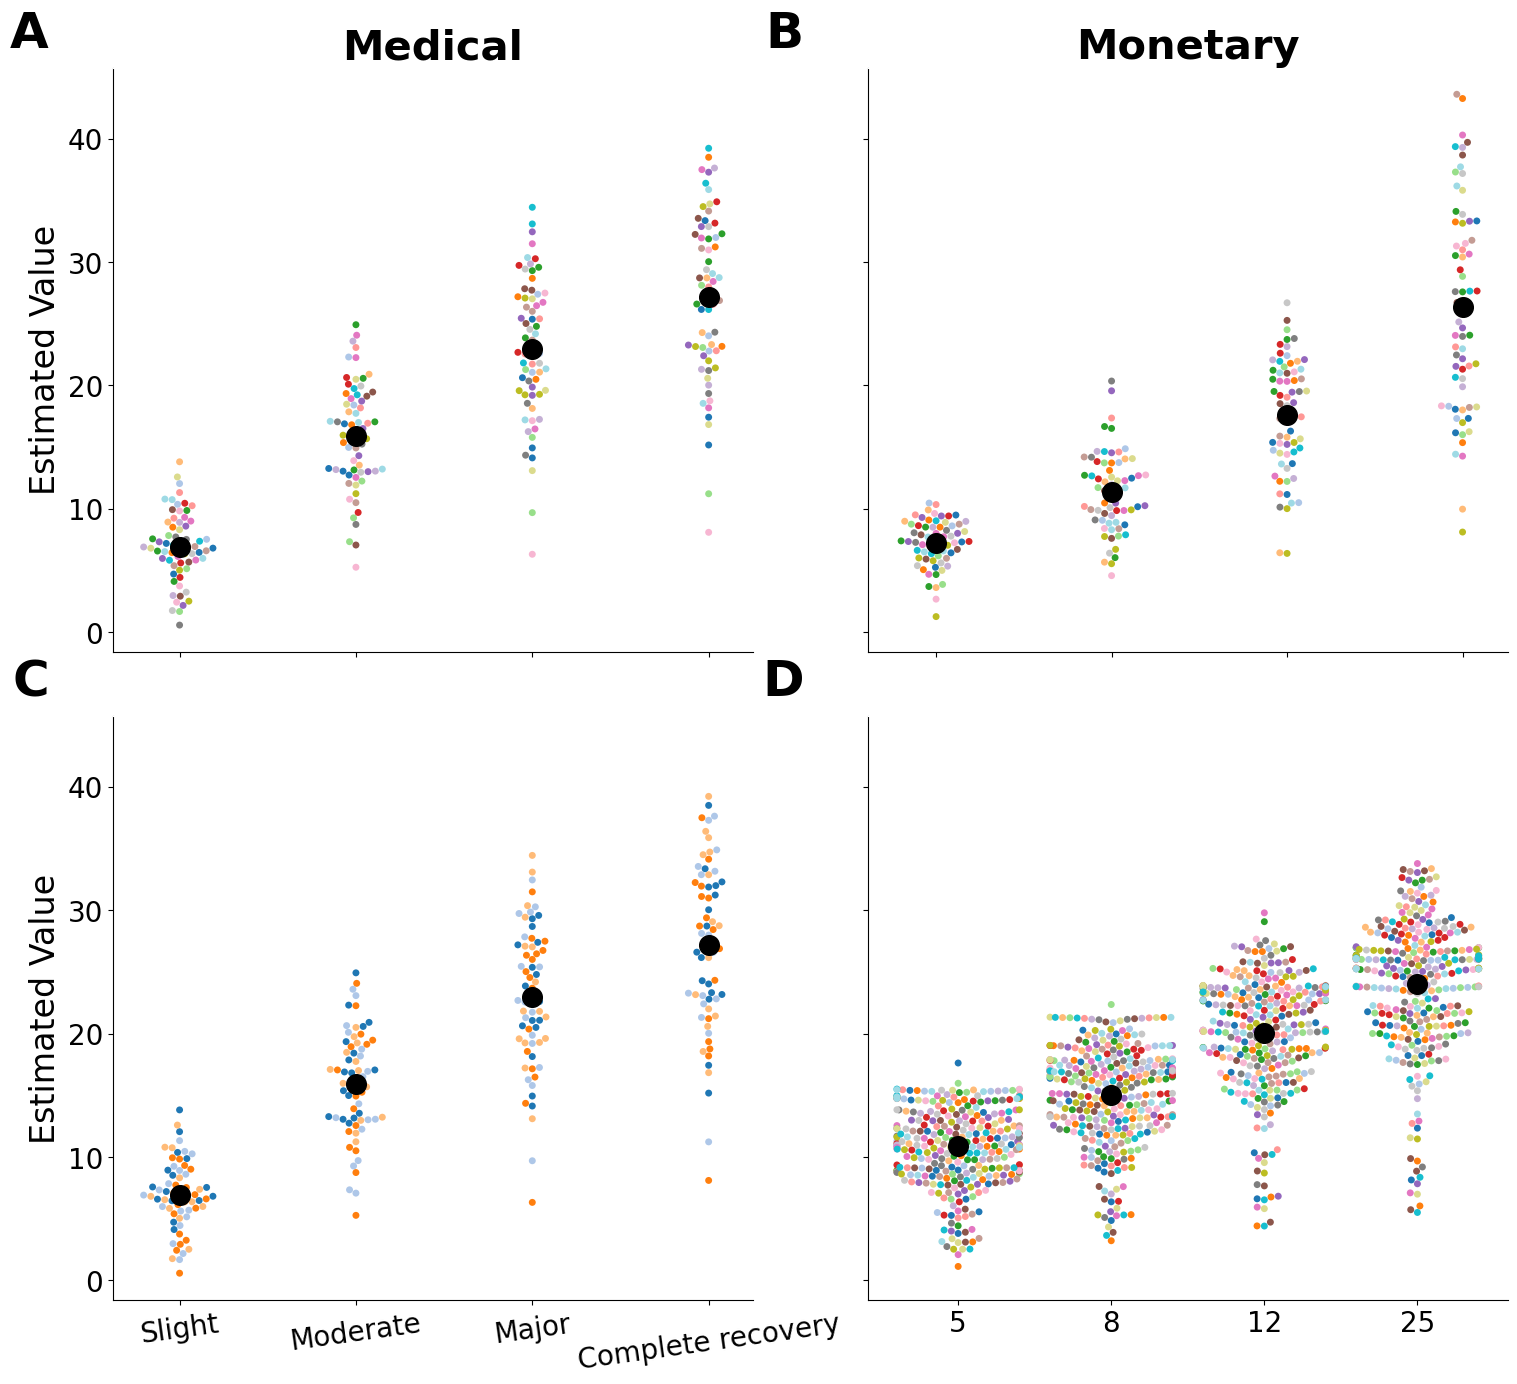

In [28]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(2, 2, figsize=(18, 16), sharey=True) # Initialize a 1x2 subplot layout, with a shared y-axis.


# Plot the estimated value for each level in the 'Medical' context on the second axis.
sns.swarmplot(data=df_long_med, x='levelName', y='value', ax=axes[0,0], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_med_online, x='levelName', y='value', ax=axes[1,0], hue = 'subn', palette = colors2)

# Plot the estimated value for each level in the 'Monetary' context on the first axis.
sns.swarmplot(data=df_long_mon, x='levelName', y='value', ax=axes[0,1], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_mon_online, x='levelName', y='value', ax=axes[1,1], hue = 'subn', palette = colors2)


# Set the title for each subplot.
axes[0,0].set_title('Medical', fontweight="bold", size=30)
axes[0,1].set_title('Monetary', fontweight="bold", size=30)

# Set the y-axis label for the first subplot.
axes[0,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[0,1].set_ylabel('', fontsize=24.0)
axes[1,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[1,1].set_ylabel('', fontsize=24.0)

axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])

# Add a slight rotation to the x-axis tick labels on the second plot for better visualization.
axes[1,0].tick_params(axis='x', labelrotation=8)

# Add the mean dots to each subplot
add_mean_dot(axes[0, 0], df_long_med, 'levelName', 'value')
add_mean_dot(axes[1, 0], df_long_med_online, 'levelName', 'value')
add_mean_dot(axes[0, 1], df_long_mon, 'levelName', 'value')
add_mean_dot(axes[1, 1], df_long_mon_online, 'levelName', 'value')

# Set the background color for both plots to white for clarity and aesthetic appeal.
for i in range(2):
    for j in range(2):
        axes[i,j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].legend_.remove()
        axes[i,j].set_facecolor('White')
        axes[i,j].set_xlabel('', fontsize=24.0)
        for spine in ['right', 'top']:
            axes[i,j].spines[spine].set_color('white')


subplot_labels = ['A', 'B', 'C', 'D']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')

# Adjust the layout to ensure that the plots do not overlap and everything fits well.
fig.subplots_adjust(hspace=0.11, wspace=0.18)  # Adjust the values as needed
#fig.tight_layout()

plt.savefig('figure2.png')

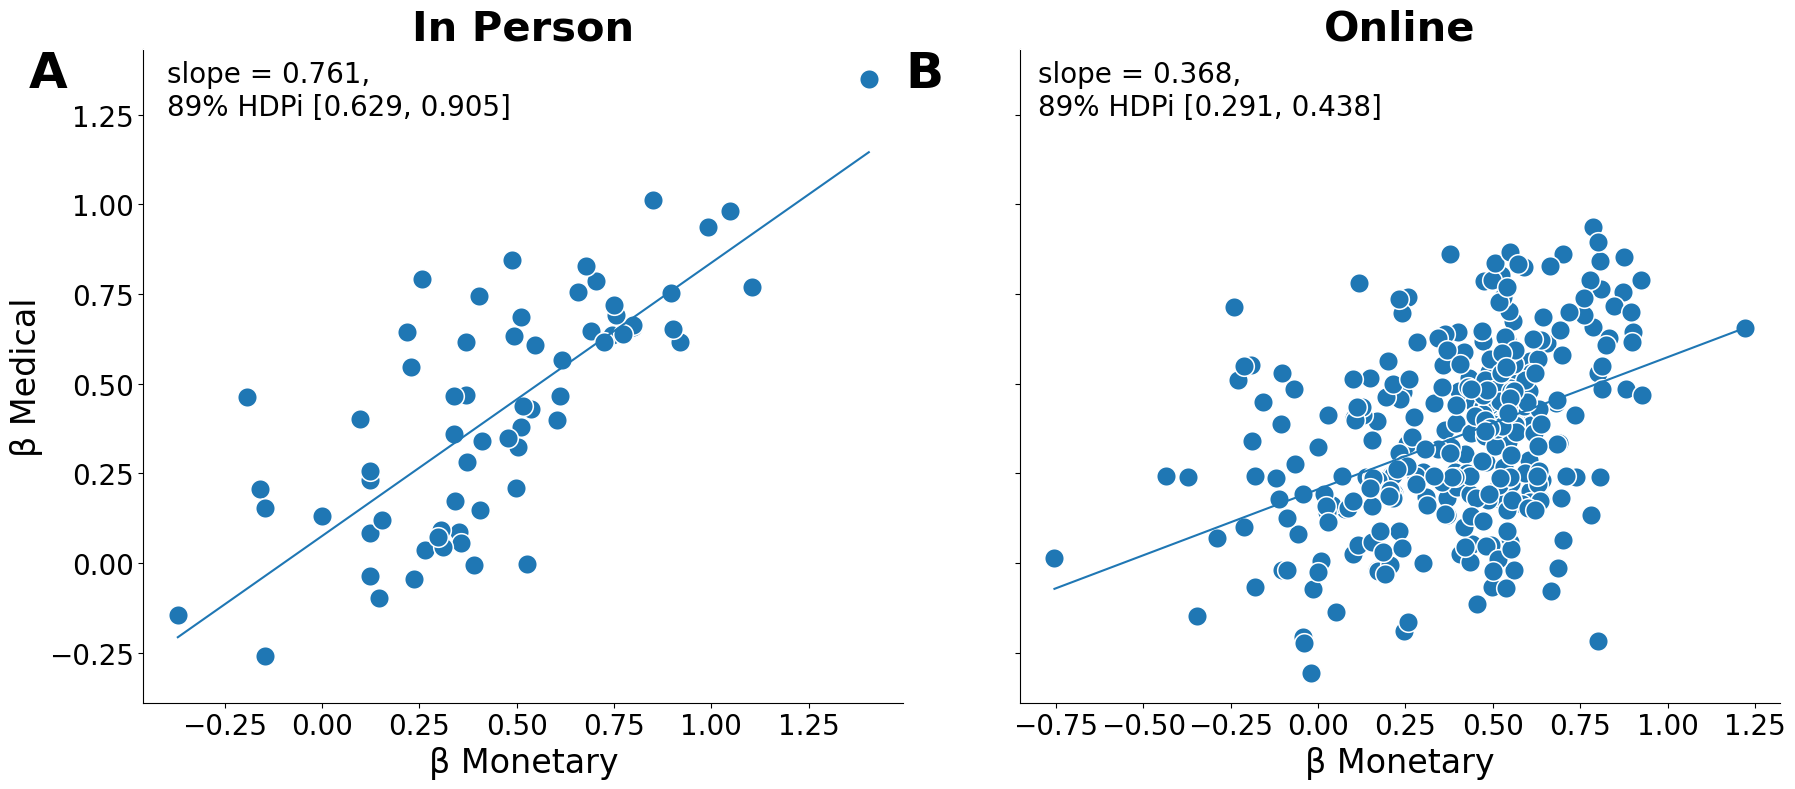

In [32]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True) # Initialize a 1x2 subplot layout, with a shared y-axis.

sns.scatterplot(data = df, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[0])
sns.lineplot(x = df.amb_est_mon, 
             y = es['mean']['intercept']+es['mean']['slope']*df.amb_est_mon, 
             ax=axes[0])

sns.scatterplot(data = df_online, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[1])
sns.lineplot(x = df_online.amb_est_mon, 
             y = es_o['mean']['intercept']+es_o['mean']['slope']*df_online.amb_est_mon, 
             ax=axes[1])

# Set the title for each subplot.
axes[0].set_title('In Person', fontweight="bold", size=30)
axes[1].set_title('Online', fontweight="bold", size=30)

texts = ['slope = {0},\n89% HDPi [{1}, {2}]'.format(es['mean']['slope'],es['hdi_5.5%']['slope'],es['hdi_94.5%']['slope']),
         'slope = {0},\n89% HDPi [{1}, {2}]'.format(es_o['mean']['slope'],es_o['hdi_5.5%']['slope'],es_o['hdi_94.5%']['slope'])]
axes[0].set_ylabel('β Medical', fontsize=24.0)

axes[0].text(-.4, 1.25, texts[0], fontsize=20)
axes[1].text(-.8, 1.25, texts[1], fontsize=20)


for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    
    axes[i].set_xlabel('β Monetary', fontsize=24.0)
    axes[i].set_facecolor('White')

    for spine in ['right', 'top']:
        axes[i].spines[spine].set_color('white')

    
    
subplot_labels = ['A', 'B']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')


fig.tight_layout()

plt.savefig('figure3.png')

## Save Models for Comparison

In [30]:
mon_simple.to_netcdf('data/mon_simple.nc')
mon_utility.to_netcdf('data/mon_utility.nc')
mon_trmbling_hand.to_netcdf('data/mon_trmbling_hand.nc')
mon_estimated.to_netcdf('data/mon_estimated.nc')
med_simple.to_netcdf('data/med_simple.nc')
med_estimated.to_netcdf('data/med_estimated.nc')

mon_simple_online.to_netcdf('data_online/mon_simple.nc')
mon_utility_online.to_netcdf('data_online/mon_utility.nc')
mon_trmbling_hand_online.to_netcdf('data_online/mon_trmbling_hand.nc')
mon_estimated_online.to_netcdf('data_online/mon_estimated.nc')
med_simple_online.to_netcdf('data_online/med_simple.nc')
med_estimated_online.to_netcdf('data_online/med_estimated.nc')

'data_online/med_estimated.nc'

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Aug 05 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

xarray: 2024.7.0

matplotlib: 3.9.1
arviz     : 0.17.1
pymc      : 4.1.7
seaborn   : 0.13.2
numpy     : 1.23.5
logging   : 0.5.1.2
pandas    : 2.2.2

Watermark: 2.4.3

